In [7]:
# Cell 1: Imports and setup
import os
import re
import nltk
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/anniii/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
# Cell 2: Load your provided document
data_path = "../data/AI Training Document.txt"
assert os.path.exists(data_path), "Your document file does not exist."

with open(data_path, 'r', encoding='utf-8') as f:
    raw_text = f.read()

print("First 500 chars of raw text:")
print(raw_text[:500])

First 500 chars of raw text:
User Agreement
1. Introduction
This User Agreement, the Mobile Application Terms of Use, and all policies and additional terms
posted on and in our sites, applications, tools, and services (collectively "Services") set out the terms
on which eBay offers you access to and use of our Services. You can find an overview of our policies
here. The Mobile Application Terms of Use, all policies, and additional terms posted on and in our
Services are incorporated into this User Agreement. You agree to co


In [9]:
# Cell 3: Clean and normalize text
def clean_text(text):
    text = re.sub(r'\n+', '\n', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\f', '', text)
    text = re.sub(r'Page \\d+', '', text)
    return text.strip()

cleaned_text = clean_text(raw_text)
print("First 500 chars of cleaned text:")
print(cleaned_text[:500])

First 500 chars of cleaned text:
User Agreement 1. Introduction This User Agreement, the Mobile Application Terms of Use, and all policies and additional terms posted on and in our sites, applications, tools, and services (collectively "Services") set out the terms on which eBay offers you access to and use of our Services. You can find an overview of our policies here. The Mobile Application Terms of Use, all policies, and additional terms posted on and in our Services are incorporated into this User Agreement. You agree to co


In [ ]:
# Cell 4: Chunk text with overlap
def chunk_text(text, chunk_size=250, overlap=50):
    sentences = nltk.sent_tokenize(text)
    chunks = []
    current_chunk = []
    current_length = 0

    for sentence in sentences:
        sentence_length = len(sentence.split())
        if current_length + sentence_length > chunk_size:
            chunks.append(' '.join(current_chunk))
            
            overlap_words = ' '.join(current_chunk).split()[-overlap:]
            current_chunk = [' '.join(overlap_words), sentence]
            current_length = len(' '.join(current_chunk).split())
        else:
            current_chunk.append(sentence)
            current_length += sentence_length

    if current_chunk:
        chunks.append(' '.join(current_chunk))
    return chunks

chunks = chunk_text(cleaned_text, chunk_size=250, overlap=50)
print(f"Total chunks: {len(chunks)}")
for i, ck in enumerate(chunks[:2]):
    print(f"Chunk {i} ({len(ck.split())} words):\n{ck[:200]}...\n")


Total chunks: 61
Chunk 0 (242 words):
User Agreement 1. Introduction This User Agreement, the Mobile Application Terms of Use, and all policies and additional terms posted on and in our sites, applications, tools, and services (collective...

Chunk 1 (249 words):
Marketplaces GmbH, Helvetiastrasse 15/17, CH-3005, Bern, Switzerland, if you reside in any other country. In this User Agreement, these entities are individually and collectively referred to as "eBay,...



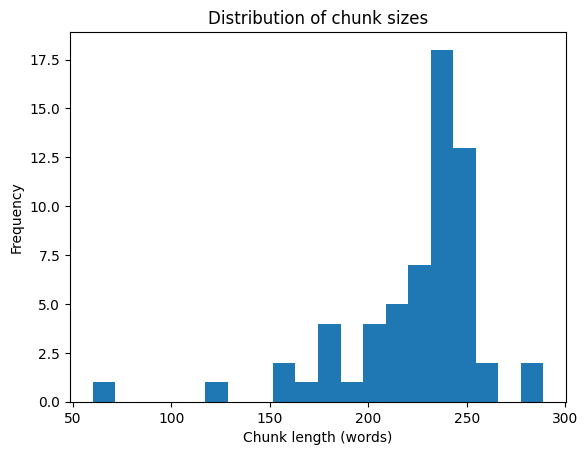

In [11]:
# Cell 5: Visualize chunk lengths

chunk_lengths = [len(ck.split()) for ck in chunks]
plt.hist(chunk_lengths, bins=20)
plt.xlabel("Chunk length (words)")
plt.ylabel("Frequency")
plt.title("Distribution of chunk sizes")
plt.show()

In [ ]:
# Cell 6: Generate embeddings using our chosen model
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(chunks, show_progress_bar=True, batch_size=32, normalize_embeddings=True)
print("Embeddings shape:", embeddings.shape)

Batches: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

Embeddings shape: (61, 384)


In [ ]:
# Cell 7: Save chunks, and build/save FAISS vector DB for our pipeline

chunks_dir = "../chunks"
vectordb_dir = "../vectordb"
if not os.path.exists(chunks_dir):
    os.makedirs(chunks_dir)
if not os.path.exists(vectordb_dir):
    os.makedirs(vectordb_dir)

# Save chunks as metadata
np.save(os.path.join(vectordb_dir, "chunk_metadata.npy"), np.array(chunks))
# Build and save FAISS index
dim = embeddings.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(embeddings)
faiss.write_index(index, os.path.join(vectordb_dir, "faiss.index"))

print(f"Saved {len(chunks)} chunks and FAISS index to {vectordb_dir}.")

Saved 61 chunks and FAISS index to ../vectordb.
